In [1]:
import sys
import os
import pandas as pd
import numpy as np
import scipy
from importlib import reload
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx


source_path = os.path.abspath("../source/")
sys.path.append(source_path)
import utils as ut
import plotting as plt2
import hypercore as hc
import matrix as matrix
import reconstruction as recon

/home/cstansbu/miniconda3/lib/python3.9/site-packages/graph_tool/draw/cairo_draw.py:32: RuntimeWarning: Error importing cairo. Graph drawing will not work.
  warnings.warn(msg, RuntimeWarning)
/home/cstansbu/miniconda3/lib/python3.9/site-packages/graph_tool/draw/cairo_draw.py:32: RuntimeWarning: Error importing cairo. Graph drawing will not work.
  warnings.warn(msg, RuntimeWarning)
/home/cstansbu/miniconda3/lib/python3.9/site-packages/graph_tool/draw/cairo_draw.py:32: RuntimeWarning: Error importing cairo. Graph drawing will not work.
  warnings.warn(msg, RuntimeWarning)
/home/cstansbu/miniconda3/lib/python3.9/site-packages/graph_tool/all.py:39: RuntimeWarning: Error importing draw module, proceeding nevertheless: No module named 'cairo._cairo'
  warnings.warn(msg, RuntimeWarning)


gt.__version__='2.58 (commit c513b9b6, )'


In [2]:
# load the population data

fpath = "/scratch/indikar_root/indikar1/shared_data/higher_order/population_pore_c/chr1_1000000_incidence.csv"

# randomly sample columns to load faster
# sample_size = 50000
# n_cols = 122676
# cols = list(range(n_cols))
# rand_cols = np.random.choice(cols, sample_size, replace=False)
# rand_cols = [str(x) for x in rand_cols]
# rand_cols.insert(0, 'bin')
# df = pd.read_csv(fpath, usecols=rand_cols)

df = pd.read_csv(fpath)
df = df.set_index('bin')
print(f"{df.shape=}")
df.head()

df.shape=(193, 122676)


43007  53640  76962  52235  15070  71405  3901  90398  95986  107241  \
bin                                                                         
4.0      0      0      0      0      0      0     0      0      0       0   
5.0      0      0      0      0      0      0     0      0      0       0   
6.0      0      0      0      0      0      0     0      0      0       0   
7.0      0      0      0      0      0      0     0      0      0       0   
8.0      0      0      0      0      0      0     0      0      0       0   

     ...  27615  44016  114747  15472  52555  53887  37027  35466  65072  \
bin  ...                                                                   
4.0  ...      0      0       0      0      0      0      0      0      0   
5.0  ...      0      0       0      0      0      0      0      0      0   
6.0  ...      0      0       0      0      0      0      0      0      0   
7.0  ...      0      0       0      0      0      0      0      0      0   
8.0  ...      0      0       0      0      0      0      0      0      0   

     114226  
bin          
4.0       0  
5.0       0  
6.0       0  
7.0       0  
8.0       0  

[5 rows x 122676 columns]

In [3]:
orders = df.sum(axis=0)

# get the degree of higher order contacts
high_order_idx = np.argwhere(orders.values > 2).ravel()
df.columns[high_order_idx].shape


(40694,)

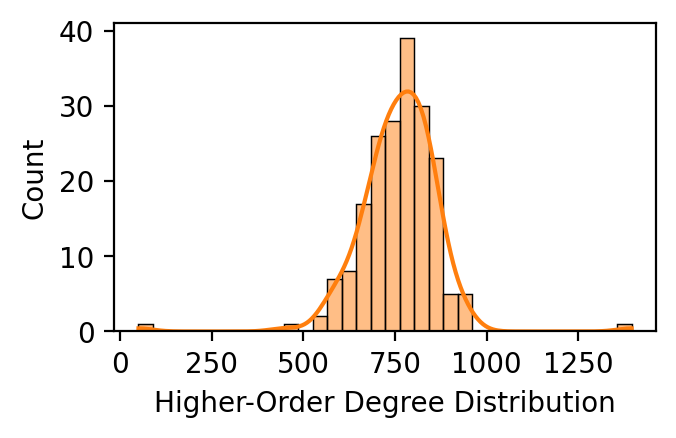

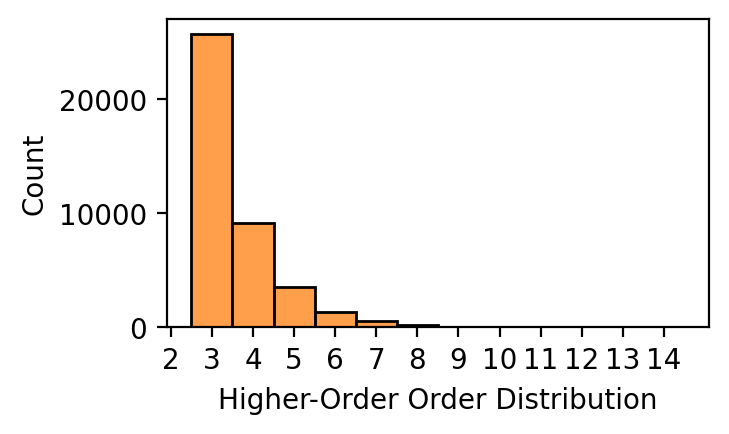

In [4]:
degrees = df.sum(axis=1)
orders = df.sum(axis=0)

# get the degree of higher order contacts
high_order_idx = np.argwhere(orders.values > 2).ravel()
ho_degrees = df[df.columns[high_order_idx]].sum(axis=1)

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 3.5, 2

sns.histplot(x=ho_degrees,
             kde=True,
             color="C1")

plt.xlabel('Higher-Order Degree Distribution')
plt.show()

sns.histplot(x=orders[orders.values > 2],
             discrete=True,
             color="C1")

plt.gca().set_xticks(sorted(np.unique(orders)))
plt.xlabel('Higher-Order Order Distribution')
plt.show()


Text(0.5, 1.0, 'Sample of 500 Hyperedges from Population Pore-C')

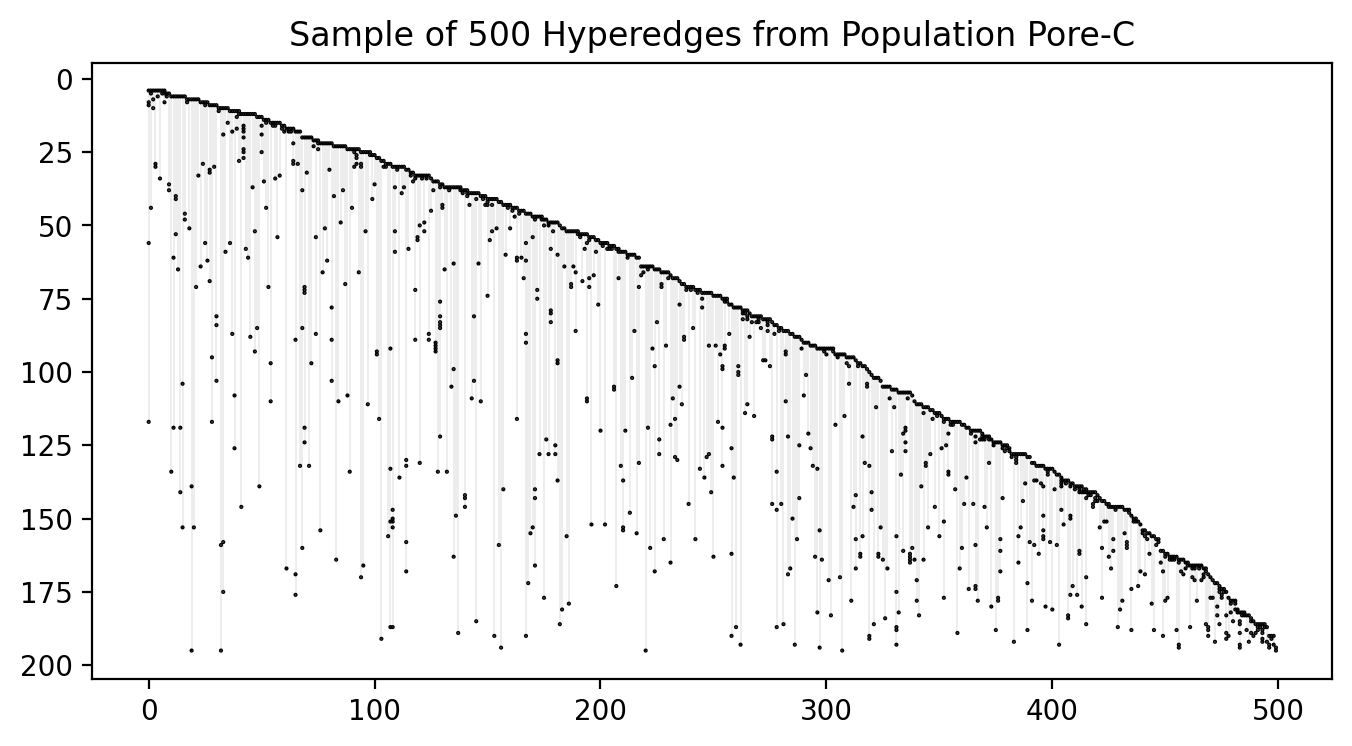

In [5]:
node_params = {
    's' : 1,
    'ec' : 'k',
    'lw' : 1,
    'marker' : ".",
    'zorder' : 2,
}

line_params = {
    'lw' : 0.1,
    'alpha' : 0.5,
    'zorder' : 1,
}

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 8, 4

sample_size = 500
plt2.plot_incidence(ut.sort_by_lowest_index(df.T.sample(sample_size).T), 
               node_color='k',
               node_params=node_params,
               line_params=line_params)

plt.title(f"Sample of {sample_size} Hyperedges from Population Pore-C")

In [6]:
# break

In [7]:
res = []

n_nodes, n_edges = df.shape
orders = df.sum(axis=0)
high_order_idx = np.argwhere(orders.values > 3).ravel()
ho_degrees = df[df.columns[high_order_idx]].sum(axis=1)

data = ut.incidence_to_list_of_list(df)
data = hc.prepare_for_hypercore_decomp(data, k=2)

M = list(range(3, 8))
K = list(range(10, 100, 2))

for k in K:
    for m in M:
        mk_hyper = hc.m_k_decomposition(data, m, k)
        
        row = {
            'm' : m,
            'k' : k,
            'nodes' : len(mk_hyper.nodes) / n_nodes ,
            'edges' : len(mk_hyper.edges) / n_edges,
        }
        res.append(row)
        
res = pd.DataFrame(res)
res.head()

m   k     nodes     edges
0  3  10  1.000000  0.294532
1  4  10  1.000000  0.120602
2  5  10  1.000000  0.047393
3  6  10  0.994819  0.018879
4  7  10  0.994819  0.007548

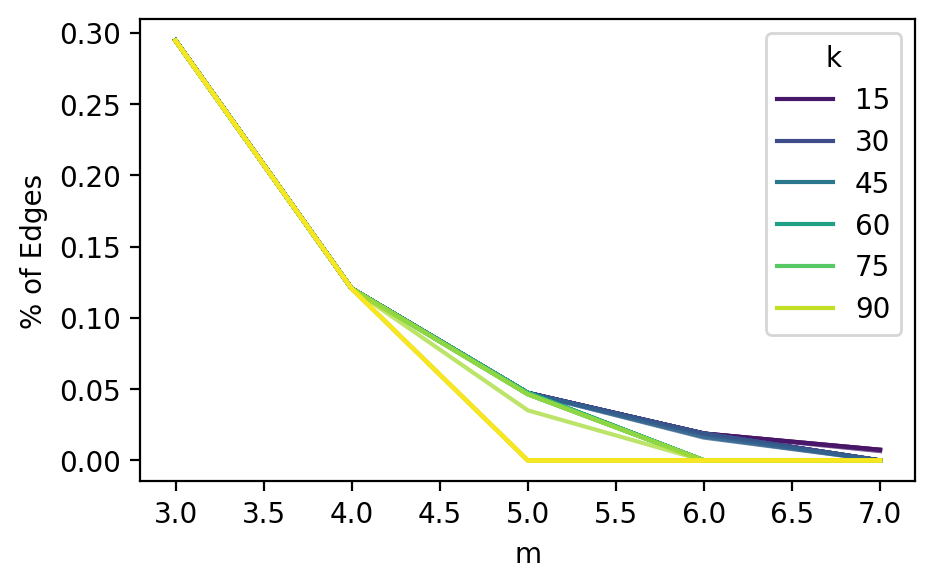

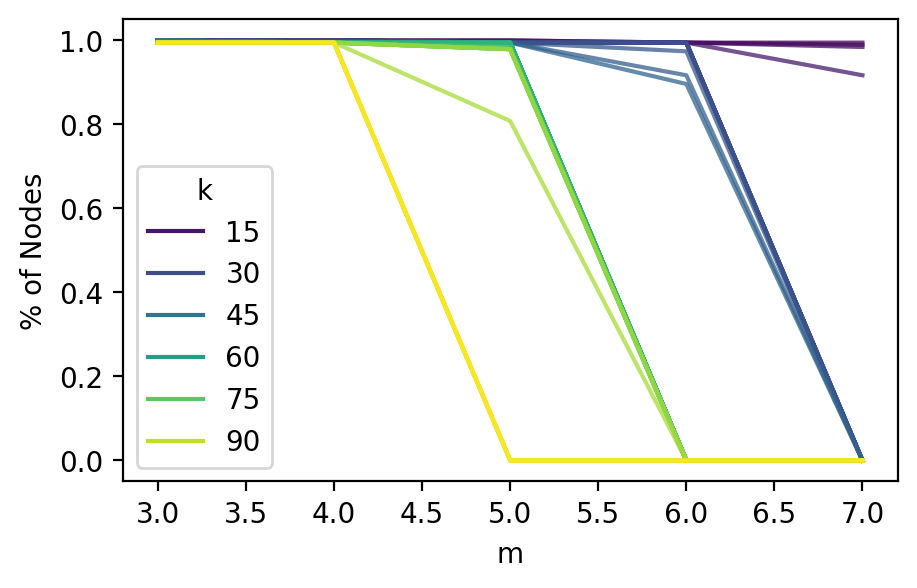

In [8]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 5, 3

sns.lineplot(data=res, 
             x='m',
             y='edges',
             hue='k',
             alpha=0.75,
             palette='viridis')

plt.ylabel("% of Edges")
plt.show()

sns.lineplot(data=res, 
             x='m',
             y='nodes',
             hue='k',
             alpha=0.75,
             palette='viridis')

plt.ylabel("% of Nodes")
plt.show()

In [9]:
m = 3
k = 453
mk_hyper = hc.m_k_decomposition(data, m, k)
print(mk_hyper)
I = hc.xgi_to_incidence(mk_hyper)

Unnamed Hypergraph with 183 nodes and 33770 hyperedges


Text(0.5, 1.0, 'Sample of 500 Hyperedges from Core')

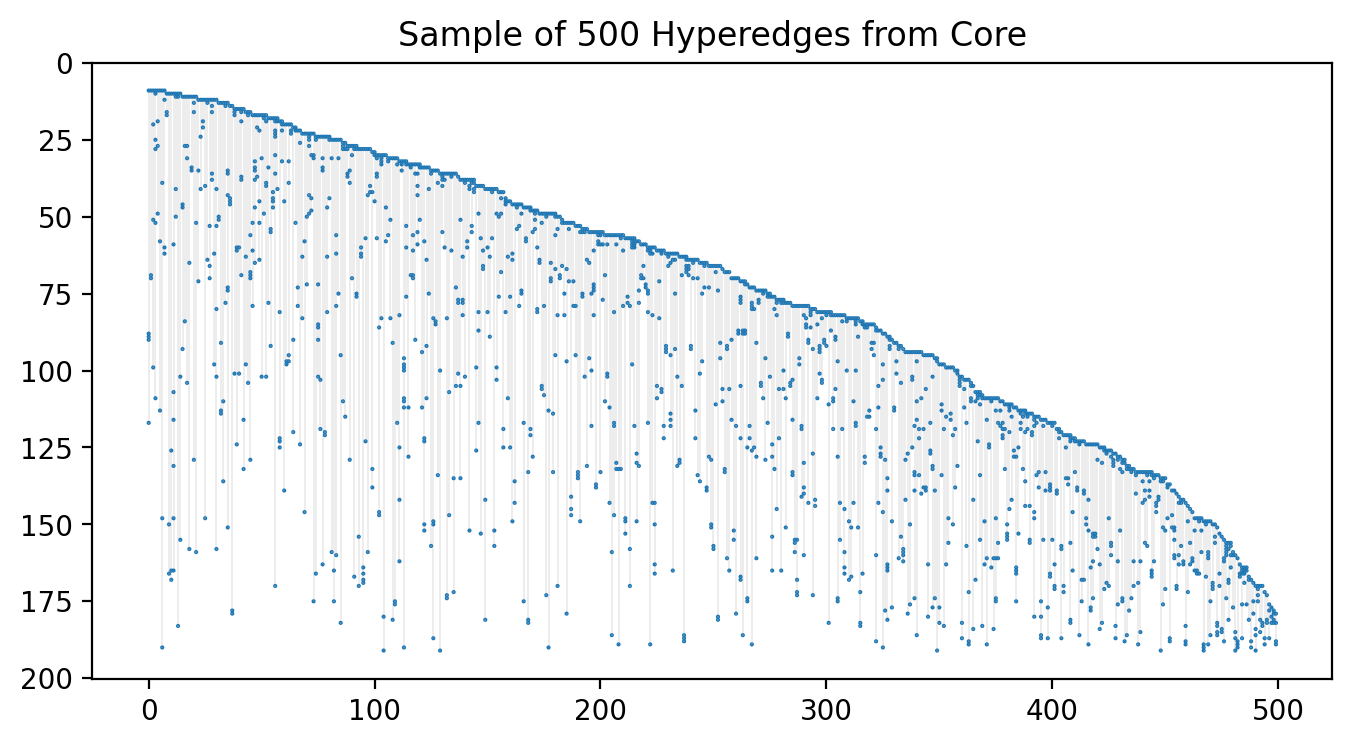

In [10]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 8, 4

node_params = {
    's' : 1,
    'ec' : 'C0',
    'lw' : 1,
    'marker' : ".",
    'zorder' : 2,
}

line_params = {
    'lw' : 0.1,
    'alpha' : 0.5,
    'zorder' : 1,
}

sample_size = 500
plt2.plot_incidence(ut.sort_by_lowest_index(I.T.sample(sample_size).T), 
               node_color='C0',
               node_params=node_params,
               line_params=line_params)

plt.title(f"Sample of {sample_size} Hyperedges from Core")

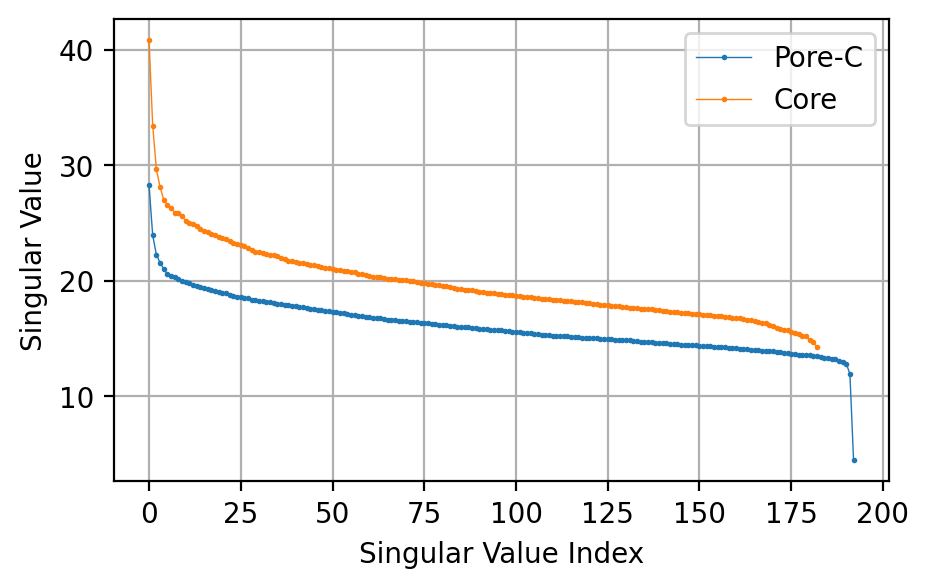

In [11]:
# Calculate singular values
sample_size = 20000
_, score, _ = np.linalg.svd(df.T.sample(sample_size).T, full_matrices=False)
_, shat, _ = np.linalg.svd(I.T.sample(sample_size).T, full_matrices=False)

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 5, 3
plt.plot(score, marker='.', markersize=2, lw=0.5, label='Pore-C')
plt.plot(shat, marker='.', markersize=2, lw=0.5, label='Core')

# plt.yscale('log')
plt.legend()
plt.xlabel("Singular Value Index")
plt.ylabel("Singular Value")
plt.grid(True)

# M = 3 core

In [12]:
m = 3
K = list(range(10, 500, 5))

data = ut.incidence_to_list_of_list(df)
data = hc.prepare_for_hypercore_decomp(data, k=2)

res = []

for k in K:
    mk_hyper = hc.m_k_decomposition(data, m, k)

    row = {
        'm' : m,
        'k' : k,
        'nodes' : len(mk_hyper.nodes) / n_nodes ,
        'edges' : len(mk_hyper.edges) / n_edges,
    }
    res.append(row)
        
res = pd.DataFrame(res)
res.head()

m   k  nodes     edges
0  3  10    1.0  0.294532
1  3  15    1.0  0.294532
2  3  20    1.0  0.294532
3  3  25    1.0  0.294532
4  3  30    1.0  0.294532

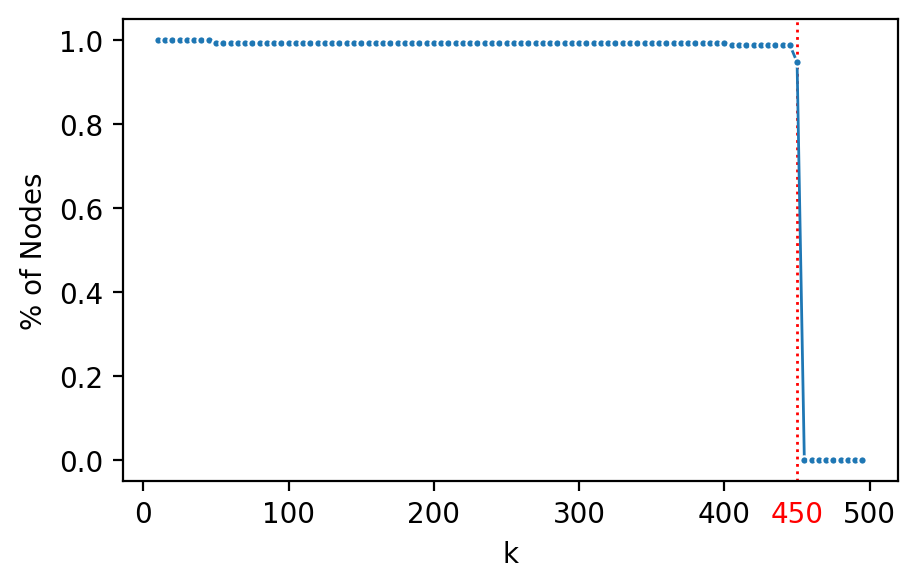

In [13]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 5, 3

sns.lineplot(data=res,
             x='k',
             lw=1,
             marker=".",
             y='nodes')


def get_knee_crude(query_values, return_values):
    """Finds the value at the first sharp change (knee) in a 1D NumPy array.

    The function calculates the absolute difference between adjacent elements in 
    the `query_values` array and finds the index of the maximum difference. This 
    index is then used to retrieve the corresponding value from the `return_values` 
    array, which is considered the knee point (sharpest change) in the data.

    Args:
        query_values: A 1D NumPy array of values to analyze for the knee point.
        return_values: A 1D NumPy array with values corresponding to the elements 
                       in `query_values`. The knee point value will be retrieved 
                       from this array.

    Returns:
        The value at the index of the first sharp change (knee) in `query_values`.
    """
    differences = np.abs(np.diff(query_values))  
    idx = np.argmax(differences) 
    return return_values[idx]

cut = get_knee_crude(res['nodes'], res['k'])

plt.axvline(x=cut, 
            lw=1, 
            ls=":", 
            zorder=0,
            c='r')

ax = plt.gca()
xtick_label = ax.get_xticklabels()[ax.get_xticks().searchsorted(cut)] 
x_text = xtick_label.get_text()  # Get the xtick label as a string

ax.text(cut, -0.041, cut, 
        ha='center', 
        va='top', 
        transform=ax.get_xaxis_transform(), 
        c='r',
        rotation=0)

plt.ylabel("% of Nodes")
plt.show()

In [14]:
m = 3
k = 450
mk_hyper = hc.m_k_decomposition(data, m, k)
print(mk_hyper)

Unnamed Hypergraph with 183 nodes and 33770 hyperedges


In [15]:
33770 / df.shape[1]

0.27527796798069715

In [16]:
# break

# Validation

In [17]:
m = 3
k = 450
mk_hyper = hc.m_k_decomposition(data, m, k)
print(mk_hyper)

I = hc.xgi_to_incidence(mk_hyper)
A = matrix.clique_expand_incidence(I, zero_diag=False)  

print(f"{I.shape=} {A.shape=}")

Unnamed Hypergraph with 183 nodes and 33770 hyperedges
I.shape=(183, 33770) A.shape=(183, 183)


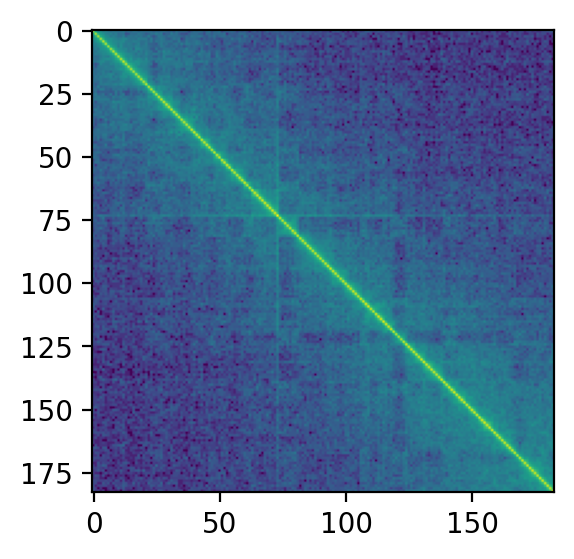

In [18]:
plt.imshow(np.log1p(A))

            mean  median
label                   
Core    3.675422     3.0
Pore-C  3.606945     3.0


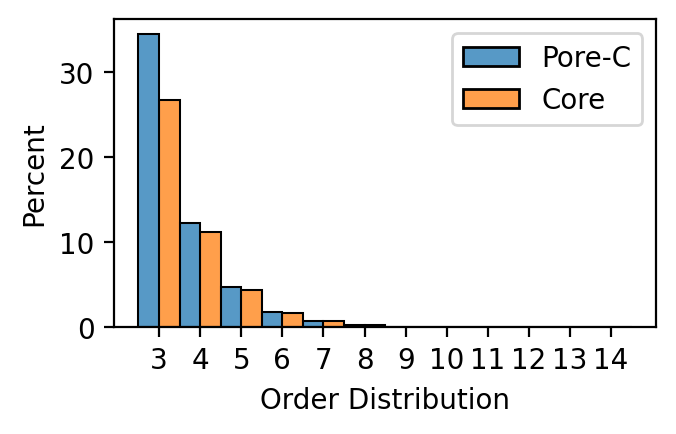

In [19]:
orders = df.sum(axis=0)
orders_core = I.sum(axis=0)

tmp = pd.DataFrame({'order': np.concatenate([orders, orders_core])})
tmp['label'] = np.where(tmp.index < len(orders), 'Pore-C', 'Core')

tmp = tmp[tmp['order'] > 2]

gx = tmp.groupby('label').agg(
    mean = ('order', 'mean'),
    median = ('order', 'median'),
)

print(gx)


plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 3.5, 2

sns.histplot(data=tmp,
             x='order',
             stat='percent',
             discrete=True,
             multiple='dodge',
             hue='label')


plt.gca().set_xticks(sorted(tmp['order'].unique()))
plt.xlabel('Order Distribution')
sns.move_legend(plt.gca(), 
                loc='upper right',
                title="")
plt.show()

# load population Hi-C

Apop.shape=(196, 196)


0    1    2      3      4     5     6    7    8    9    ...  186  187  188  \
0    0    0    0      0      0     0     0    0    0    0  ...    0    0    0   
1    0    0    0      0      0     0     0    0    0    0  ...    0    0    0   
2    0    0    0      0      0     0     0    0    0    0  ...    0    0    0   
3    0    0    0  51610   5155   921   512  361  320  423  ...    4    3    5   
4    0    0    0   5155  66793  4580  1135  498  296  559  ...    7    4    4   

   189  190  191  192  193  194  195  
0    0    0    0    0    0    0    0  
1    0    0    0    0    0    0    0  
2    0    0    0    0    0    0    0  
3    2    4    3    5    3    2    3  
4    5    4    7    4    7    1    0  

[5 rows x 196 columns]

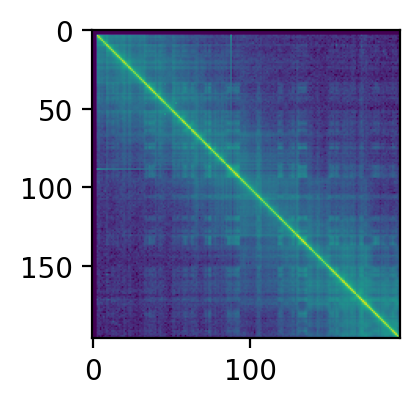

In [20]:
fpath = "/scratch/indikar_root/indikar1/shared_data/higher_order/population_hic/chr1_1000000.csv"

Apop = pd.read_csv(fpath)
Apop.index = Apop.index.astype(int)
Apop.columns = Apop.columns.astype(int)
print(f"{Apop.shape=}")

plt.imshow(np.log1p(Apop))
Apop.head()

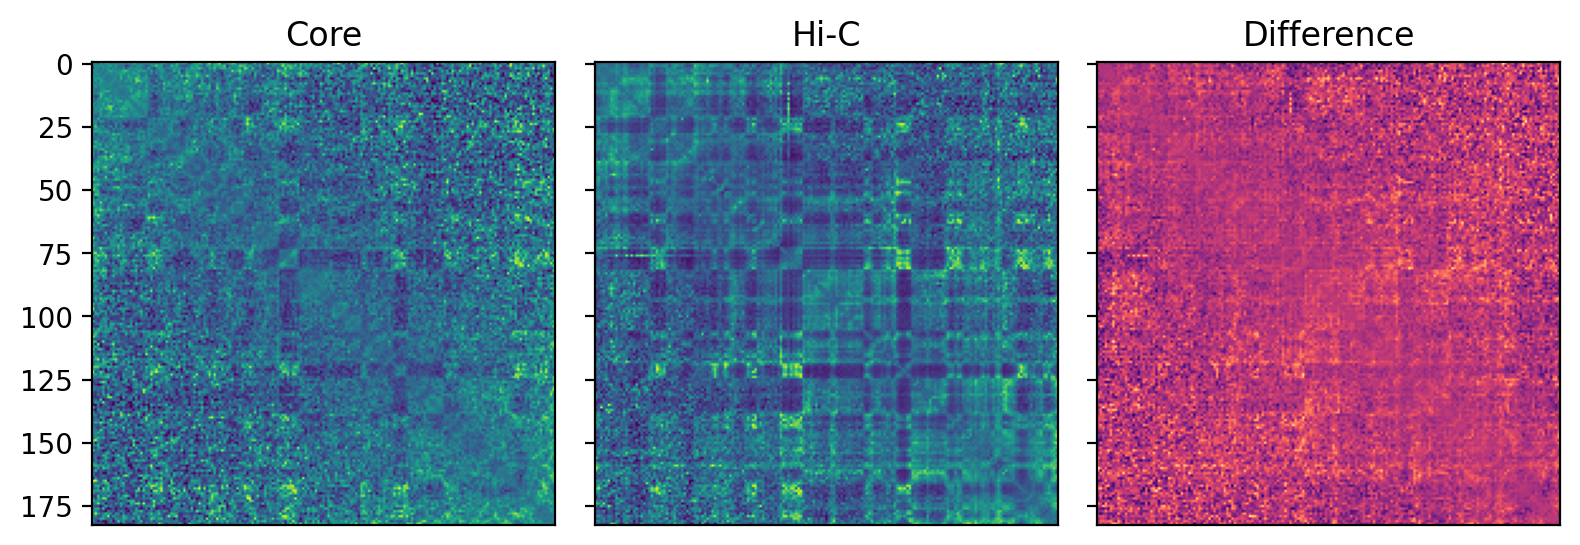

In [21]:
reload(matrix)
nudge = 3
Ahat = Apop.iloc[A.index + nudge].copy()
Ahat = Ahat[A.index + nudge]

Ahat = matrix.normalize_oe(matrix.normalize_kr(Ahat).todense())
Acore = matrix.normalize_oe(matrix.normalize_kr(A).todense())

n_outlier = 100
Ahat = matrix.handle_outliers(Ahat, n_outlier)
Acore = matrix.handle_outliers(Acore, n_outlier)

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 8, 4
fig, axs = plt.subplots(1, 3, sharey=True)

axs[0].imshow(Acore)
axs[0].set_title('Core')
axs[0].set_xticks([])

axs[1].imshow(Ahat)
axs[1].set_title('Hi-C')
axs[1].set_xticks([])

axs[2].imshow(Ahat - Acore, cmap='magma')
axs[2].set_title('Difference')
axs[2].set_xticks([])

plt.tight_layout()

# Scree plots

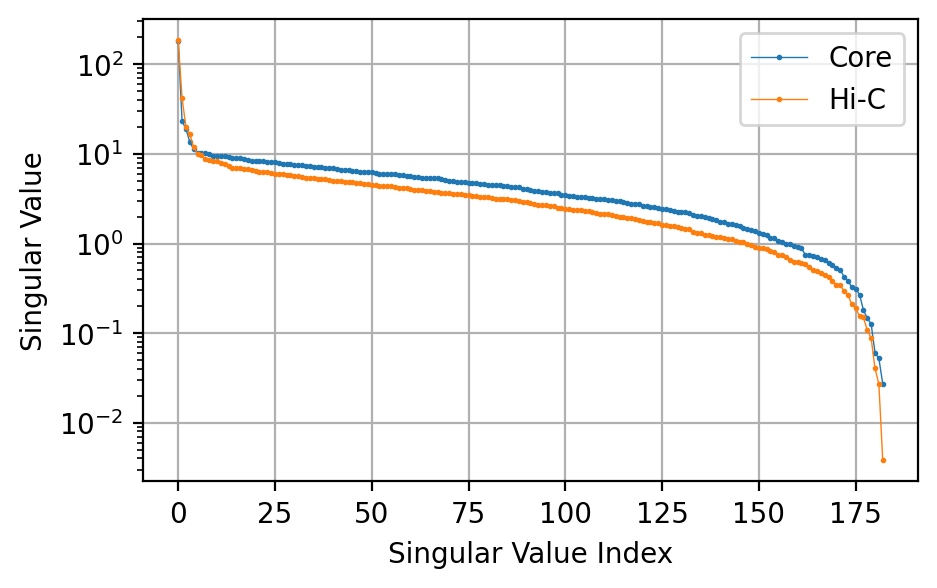

In [31]:
# Calculate singular values
_, score, _ = np.linalg.svd(Acore, full_matrices=False)
_, shat, _ = np.linalg.svd(Ahat, full_matrices=False)

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 5, 3
plt.plot(score, marker='.', markersize=2, lw=0.5, label='Core')
plt.plot(shat, marker='.', markersize=2, lw=0.5, label='Hi-C')

plt.yscale('log')
plt.legend()
plt.xlabel("Singular Value Index")
plt.ylabel("Singular Value")
plt.grid(True)

In [23]:
# break

# compare core to population

A_porec.shape=(193, 193)


/home/cstansbu/git_repositories/higher-order-single-cell/source/matrix.py:134: RuntimeWarning: invalid value encountered in divide
  normalized_matrix = np.divide(matrix, toeplitz_matrix)


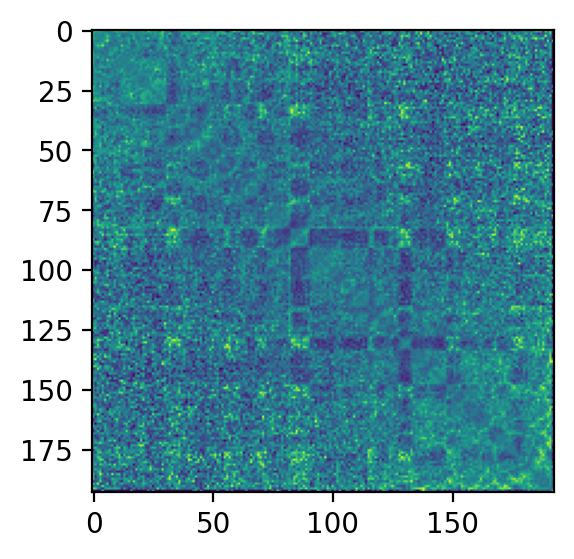

In [24]:
# clique-expand the population data
A_porec = A = matrix.clique_expand_incidence(df, zero_diag=False)  
A_porec = A_porec.loc[A.index].copy()
A_porec = A_porec[A.index]
print(f"{A_porec.shape=}")

A_porec = matrix.normalize_oe(matrix.normalize_kr(A_porec).todense())

n_outlier = 100
A_porec = matrix.handle_outliers(A_porec, n_outlier)

plt.imshow(A_porec)

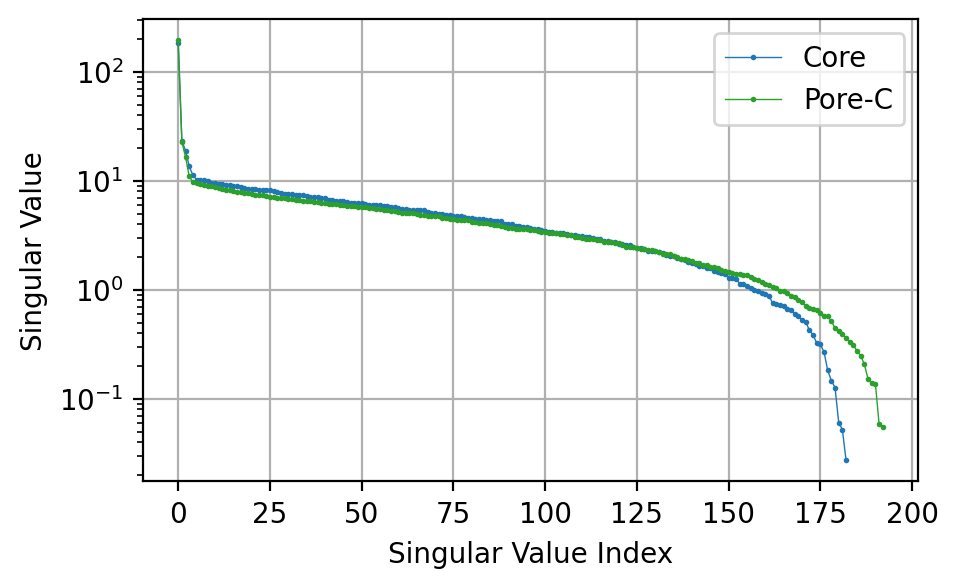

In [32]:
# Calculate singular values
_, score, _ = np.linalg.svd(Acore, full_matrices=False)
_, sporec, _ = np.linalg.svd(A_porec, full_matrices=False)

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 5, 3
plt.plot(score, marker='.', markersize=2, lw=0.5, label='Core')
plt.plot(sporec, marker='.', c='C2', markersize=2, lw=0.5, label='Pore-C')

plt.yscale('log')
plt.legend()
plt.xlabel("Singular Value Index")
plt.ylabel("Singular Value")
plt.grid(True)

# Centrality compairison 

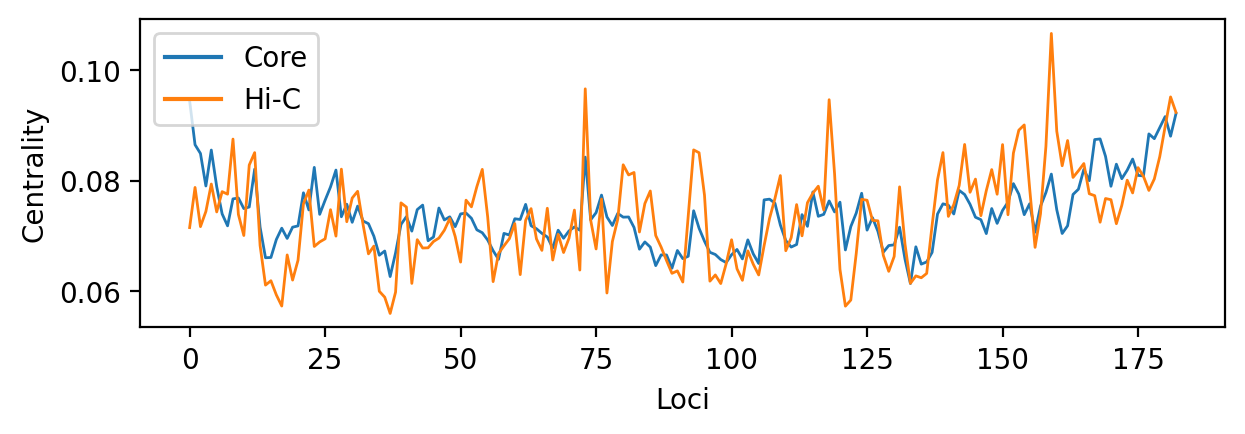

label      Core      Hi-C
label                    
Core   1.000000  0.588914
Hi-C   0.588914  1.000000

In [26]:
def get_centralities(mats, labels):
    """A function to return centralities """
    
    res = []
    for mat, label in zip(mats, labels):
        G = nx.from_numpy_array(mat)
        tmp = nx.eigenvector_centrality(G, weight='weight')
        tmp = pd.DataFrame({
            'bin' : tmp.keys(),
            'value' : tmp.values(),
        })
        tmp['label'] = label
        tmp['measure'] = 'eigenvector_centrality'
    
        res.append(tmp)
        
    return pd.concat(res)
        
res = get_centralities([Acore, Ahat], ['Core', 'Hi-C'])    
res.head()

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 7, 2
sns.lineplot(data=res, 
             x='bin',
             y='value',
             hue='label',
             lw=1,)

sns.move_legend(plt.gca(), 
                loc='upper left',
                title="")

plt.xlabel('Loci')
plt.ylabel('Centrality')

plt.show()

tmp = pd.pivot_table(res, 
               index='bin', 
               columns='label', 
               values='value')

tmp.corr()

# Between-ness

In [35]:
# Gcore = nx.from_numpy_array(Acore)
# Ghat = nx.from_numpy_array(Ahat)

# core_btw = nx.edge_betweenness_centrality(Gcore, weight='weight')
# hat_btw = nx.edge_betweenness_centrality(Ghat, weight='weight')

# tmp = pd.DataFrame({'bin1' : [x[0] for x in hat_btw.keys()],
#                     'bin2' : [x[1] for x in hat_btw.keys()],
#                     'key' : hat_btw.keys()})

# tmp['Core'] = tmp['key'].map(core_btw)
# tmp['Hi-C'] = tmp['key'].map(hat_btw)


# tmp = tmp[tmp['Core'].notna()]
# tmp = tmp[tmp['Hi-C'].notna()]

# scipy.stats.pearsonr(tmp['Core'].values, tmp['Hi-C'].values)

In [29]:
# break

SyntaxError: 'break' outside loop (668683560.py, line 1)

# Variable k

In [36]:
m = 3
n_outlier = 100
res = []

for k in [10, 110, 210, 310, 410]:
    print(f"{k=}...")
    mk_hyper = hc.m_k_decomposition(data, m, k)
    print(mk_hyper)
    Itest = hc.xgi_to_incidence(mk_hyper)
    Atest = matrix.clique_expand_incidence(Itest, zero_diag=False)  
    
    nudge = 3
    Ahat = Apop.iloc[Atest.index + nudge].copy()
    Ahat = Ahat[Atest.index + nudge]

    Ahat = matrix.normalize_oe(matrix.normalize_kr(Ahat).todense())
    Atest = matrix.normalize_oe(matrix.normalize_kr(Atest).todense())
    
    Ahat = matrix.handle_outliers(Ahat, n_outlier)
    Atest = matrix.handle_outliers(Atest, n_outlier)
    
    row = {
        'k' : k,
        'norm' : np.linalg.norm(Ahat - Atest),
    }
        
    res.append(row)
    
res = pd.DataFrame(res)
res.head()

k=10...
Unnamed Hypergraph with 193 nodes and 36132 hyperedges


/home/cstansbu/git_repositories/higher-order-single-cell/source/matrix.py:134: RuntimeWarning: invalid value encountered in divide
  normalized_matrix = np.divide(matrix, toeplitz_matrix)


k=110...
Unnamed Hypergraph with 192 nodes and 36110 hyperedges
k=210...
Unnamed Hypergraph with 192 nodes and 36110 hyperedges
k=310...
Unnamed Hypergraph with 192 nodes and 36110 hyperedges
k=410...
Unnamed Hypergraph with 191 nodes and 35858 hyperedges


k        norm
0   10  101.728429
1  110   99.181563
2  210   99.181563
3  310   99.181563
4  410   98.388211

Text(0, 0.5, '$||A_{core} - A_{hic}||_F$')

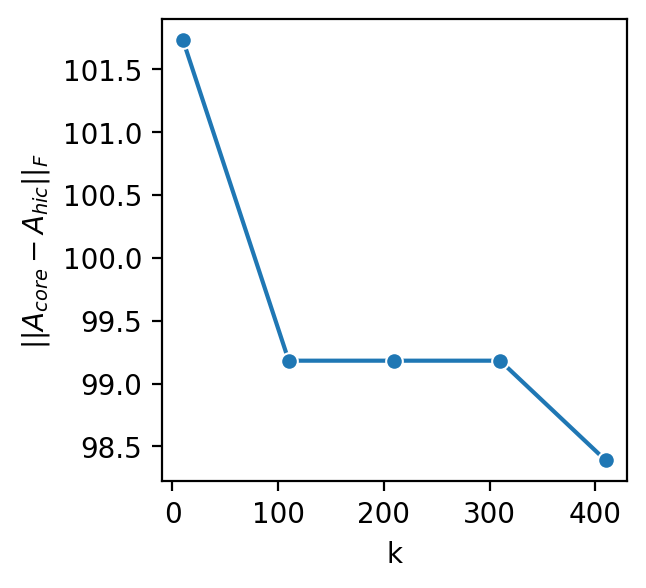

In [45]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 3, 3

sns.lineplot(data=res,
             x='k',
             marker="o",
             y='norm')

plt.ylabel(r"$||A_{core} - A_{hic}||_F$")

# Permutation test

In [62]:
# @TODO

# Larntz-Perlman

In [66]:
# reprocess the data
m = 3
k = 100
mk_hyper = hc.m_k_decomposition(data, m, k)
print(mk_hyper)

I = hc.xgi_to_incidence(mk_hyper)
A = matrix.clique_expand_incidence(I, zero_diag=False)  

print(f"{I.shape=} {A.shape=}")

reload(matrix)
nudge = 3
Ahat = Apop.iloc[A.index + nudge].copy()
Ahat = Ahat[A.index + nudge]

Ahat = matrix.normalize_oe(matrix.normalize_kr(Ahat).todense())
Acore = matrix.normalize_oe(matrix.normalize_kr(A).todense())

n_outlier = 100
Ahat = matrix.handle_outliers(Ahat, n_outlier)
Acore = matrix.handle_outliers(Acore, n_outlier)

print(f"{Ahat.shape=} {Acore.shape=}")

Unnamed Hypergraph with 192 nodes and 36110 hyperedges
I.shape=(192, 36110) A.shape=(192, 192)
Ahat.shape=(192, 192) Acore.shape=(192, 192)


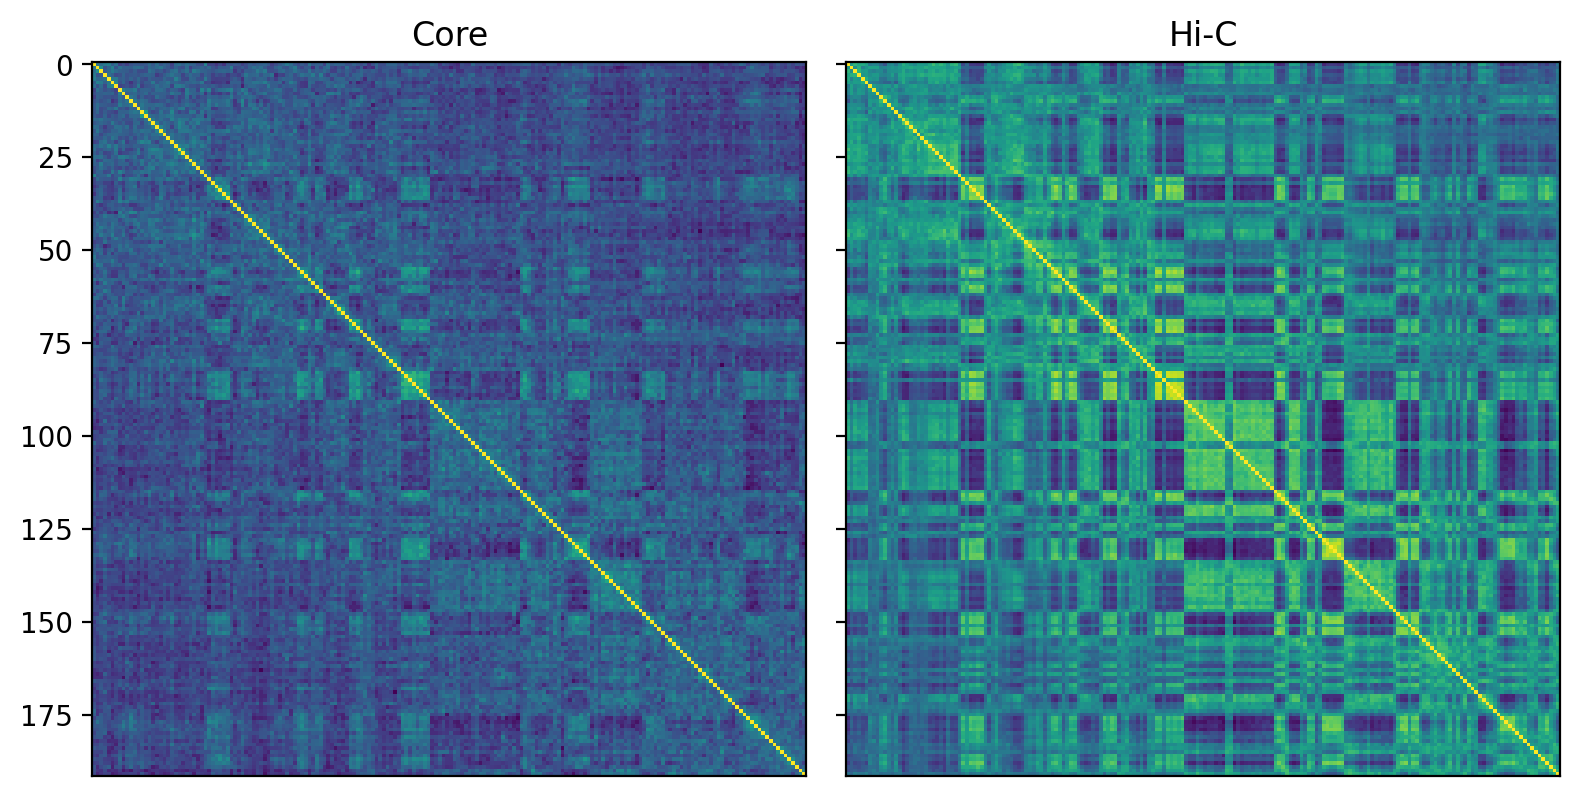

In [67]:
reload(matrix)

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 8, 4
fig, axs = plt.subplots(1, 2, sharey=True)

Acore_corr = np.corrcoef(Acore)
Ahat_corr = np.corrcoef(Ahat)

axs[0].imshow(Acore_corr)
axs[0].set_title('Core')
axs[0].set_xticks([])

axs[1].imshow(Ahat_corr)
axs[1].set_title('Hi-C')
axs[1].set_xticks([])

plt.tight_layout()

Reject H0: False p_value=1.0


Text(0.5, 1.0, 'LP Test $H_0:A_{core} = A_{hic}$ ')

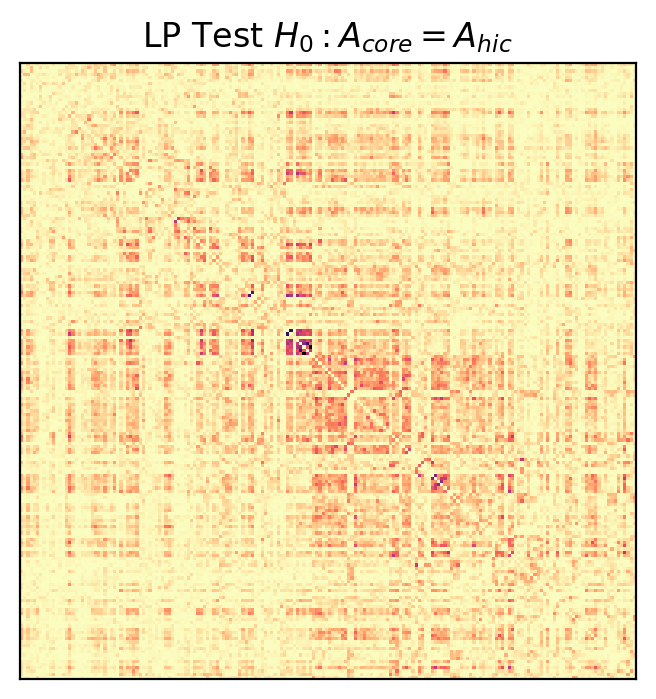

In [118]:
reload(matrix)

"""
Rejecting the null hypothesis suggests that the two correlation matrices provide evidence of 
distinct relationships between the variables they represent. There's a statistically significant difference 
in the way correlations are structured within the matrices.
"""

h0, p_mat, s_mat, p_value = matrix.larntzPerlman(Acore_corr, Ahat_corr, sample_size=2)
print(f"Reject H0: {~h0} {p_value=}") 

plt.imshow(s_mat, cmap='magma')
_ = plt.xticks([])
_ = plt.yticks([])
plt.title(r"LP Test $H_0:A_{core} = A_{hic}$ ")

# Reconstruction

In [120]:
# reprocess the data
m = 3
k = 450
mk_hyper = hc.m_k_decomposition(data, m, k)
print(mk_hyper)

I = hc.xgi_to_incidence(mk_hyper)
A = matrix.clique_expand_incidence(I, zero_diag=False)  

print(f"{I.shape=} {A.shape=}")

reload(matrix)
nudge = 3
Ahat = Apop.iloc[A.index + nudge].copy()
Ahat = Ahat[A.index + nudge]

Ahat = matrix.normalize_oe(matrix.normalize_kr(Ahat).todense())
Acore = matrix.normalize_oe(matrix.normalize_kr(A).todense())

n_outlier = 100
Ahat = matrix.handle_outliers(Ahat, n_outlier)
Acore = matrix.handle_outliers(Acore, n_outlier)

print(f"{Ahat.shape=} {Acore.shape=}")

# # reconstruct the hi-c data
# ghat = recon.create_graph_tools_from_adjacency(Ahat)
# h_hat = recon.learn_hyperedges_mcmc(ghat, niter=10)

# print(f"{len(h_hat)=}")

Unnamed Hypergraph with 183 nodes and 33770 hyperedges
I.shape=(183, 33770) A.shape=(183, 183)
Ahat.shape=(183, 183) Acore.shape=(183, 183)


In [ ]:
Acore.shape
Ahat.shape

# compare the reconstructions of both 

In [ ]:
break

# test

In [ ]:
reload(matrix)
m = 5
k = 86
mk_hyper = hc.m_k_decomposition(data, m, k)
print(mk_hyper)
I = hc.xgi_to_incidence(mk_hyper)

node_params = {
    's' : 1,
    'ec' : 'C3',
    'lw' : 1,
    'marker' : ".",
    'zorder' : 2,
}

line_params = {
    'lw' : 0.1,
    'alpha' : 0.5,
    'zorder' : 1,
}

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 8, 4
sample_size = 500
plt2.plot_incidence(ut.sort_by_lowest_index(I.T.sample(sample_size).T), 
               node_color='C3',
               node_params=node_params,
               line_params=line_params)

plt.title(f"Sample of {sample_size} Hyperedges from {m, k}-Core")
nodes = I.shape[0] / df.shape[0]
edges = I.shape[1] / df.shape[1]
print(f"{nodes=:.3f} {edges=:.3f}")

In [ ]:
A = matrix.clique_expand_incidence(I, zero_diag=False)   

A = matrix.remove_indices(A.to_numpy(), [82, 85, 192])
print(f"{A.shape=}")

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 3, 3
plt.imshow(matrix.normalize_oe(matrix.normalize_kr(A).todense()))
plt.title(f'{m, k}-Core Hypergraph')
plt.xticks([])
plt.show()

In [ ]:
break